In [416]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
from shapely.geometry import shape
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

% matplotlib inline

In [344]:
# Load the synthetic WF data as a pandas dataframe
wf_indivs = pd.read_csv('../Data/Synthetic_WF.csv',index_col=0)
wf_indivs.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,f_workdis,ward
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590
3,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590
4,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590


In [345]:
# Let's look at the work distance variable. Remember, the question for this is:
# About how far, in miles, do you live from your usual place of work?

In [346]:
# code missing to single variable. -7 = proxy, -8 = inapplicable, -2 = refusal, -1 = don't know, -10 = not in ethnic boost
wf_indivs['work_dis_class'] = wf_indivs['f_workdis'].apply(lambda x: np.nan if np.sign(x) == -1 else 1.0)

In [353]:
# Clean the workdis variable

# Code the inapplicable f_workdis to 'inapplicable'
wf_indivs['workdis'] = wf_indivs['f_workdis'].apply(lambda x: 'inapplicable' if x == -8 else x)
# Code the worktrav 'inapplicable's to workdis inapplicables
wf_indivs.loc[wf_indivs['worktrav'] == 'inapplicable','workdis'] = 'inapplicable'
# code 'workdis' = -7 to 'home'
wf_indivs.loc[wf_indivs['workdis']==-7,'workdis'] = 'home'
# code 'workdis' inapplicable and worktrav home to home
wf_indivs.loc[(wf_indivs['workdis']=='inapplicable')&(wf_indivs['worktrav']=='Home'),'workdis'] = 'home'
# code 'workdis' -10 and worktrav home to home
wf_indivs.loc[(wf_indivs['workdis']==-10)&(wf_indivs['worktrav']=='Home'),'workdis'] = 'home'

# The rest of the data is missing, and hard to clean, so we'll code it to missing.
wf_indivs['workdis'] = wf_indivs['workdis'].apply(lambda x: 'missing' if str(x)[0] == '-' else x)

In [354]:
pd.crosstab(wf_indivs['workdis'].replace(to_replace=bins, value = 'journey'),wf_indivs['worktrav'])

worktrav,Car,Cycle,Home,Public,Walk,inapplicable
workdis,,,,,,
home,0,0,9220,0,0,0
inapplicable,0,0,0,0,0,70592
journey,23962,2277,0,36649,4880,0
missing,12416,962,0,27440,2580,0


In [355]:
wf_indivs['workdis'].replace(to_replace=bins, value = 'journey').value_counts().to_frame(name='count').merge(
wf_indivs['workdis'].replace(to_replace=bins, value = 'journey').value_counts(normalize = True).to_frame(name='proportion'), left_index =True, right_index = True)
# We have data for 1/3 of the journeys

,count,proportion
inapplicable,70592,0.369634
journey,67768,0.354847
missing,43398,0.227241
home,9220,0.048278


In [356]:
# Let's have a look at the distribution of workdis, for those we know.
dists = wf_indivs.loc[wf_indivs['workdis'].map(np.isreal),'workdis']
dists = pd.to_numeric(dists)

Text(0,0.5,'Frequency')

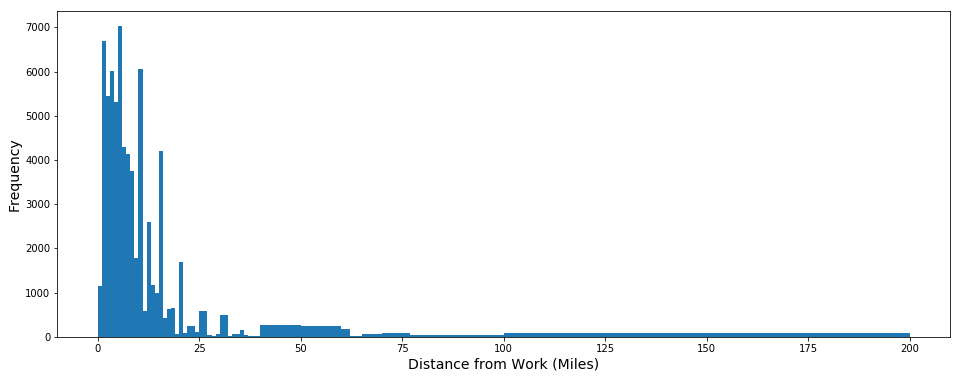

In [357]:
f, ax = plt.subplots(figsize = (16,6))

bins = np.array(sorted(dists.unique()))
ax.hist(dists,bins)
ax.set_xlabel('Distance from Work (Miles)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)

# This doesn't look like the Census Flow data we have already seen.

1.274263342262518

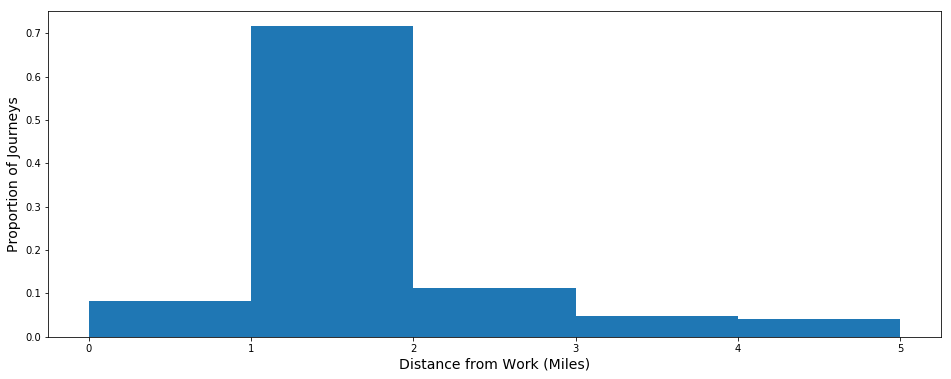

In [360]:
# Let's look at the breakdown of distances travelled by travel mode.
walkdists = wf_indivs.loc[(wf_indivs['workdis'].map(np.isreal))&(wf_indivs['worktrav'] == 'Walk'),'workdis']
walkdists = pd.to_numeric(walkdists)

f, ax = plt.subplots(figsize = (16,6))

# 'hilariously' someone claims to walk 200 miles to work. So ignore that.
bins = np.array(sorted(walkdists.unique()))[:-1]
ax.hist(walkdists,bins,density=True)
ax.set_xlabel('Distance from Work (Miles)',fontsize=14)
ax.set_ylabel('Proportion of Journeys',fontsize=14)

walkdists[walkdists < 200].mean() # mean distance is 1.27 miles, c. 2km (excluding 200 mile journeys)

4.587176108915239

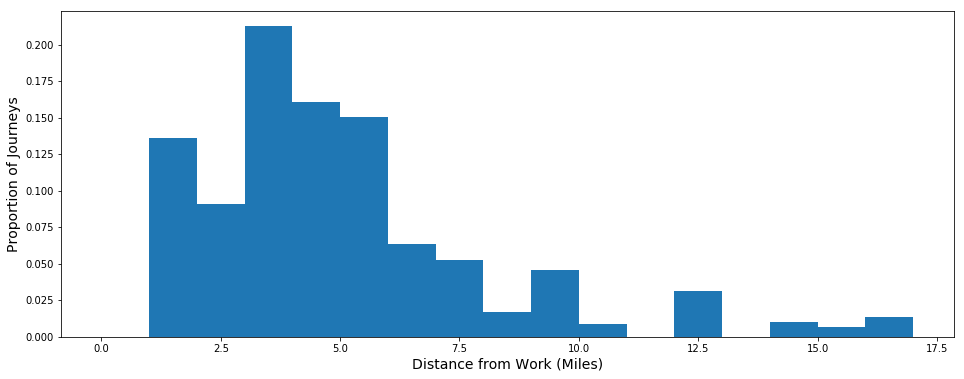

In [361]:
# Let's look at the breakdown of distances travelled by travel mode.
cycledists = wf_indivs.loc[(wf_indivs['workdis'].map(np.isreal))&(wf_indivs['worktrav'] == 'Cycle'),'workdis']
cycledists = pd.to_numeric(cycledists)

f, ax = plt.subplots(figsize = (16,6))

bins = np.arange(0,18,1)
ax.hist(cycledists,bins,density=True)
ax.set_xlabel('Distance from Work (Miles)',fontsize=14)
ax.set_ylabel('Proportion of Journeys',fontsize=14)

cycledists.mean() # mean cycle dist is 4.59 miles, c. 7.4 km

9.388141559114846

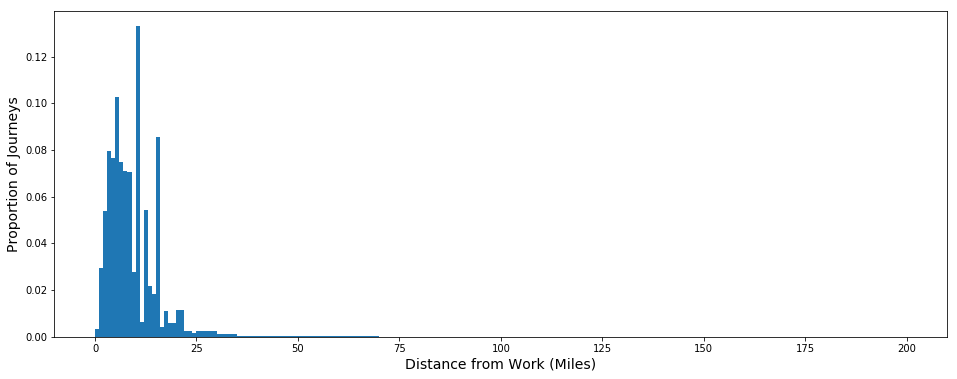

In [362]:
# Let's look at the breakdown of distances travelled by public transport.
publicdists = wf_indivs.loc[(wf_indivs['workdis'].map(np.isreal))&(wf_indivs['worktrav'] == 'Public'),'workdis']
publicdists = pd.to_numeric(publicdists)

f, ax = plt.subplots(figsize = (16,6))

bins = np.array(sorted(publicdists.unique()))
ax.hist(publicdists,bins,density=True)
ax.set_xlabel('Distance from Work (Miles)',fontsize=14)
ax.set_ylabel('Proportion of Journeys',fontsize=14)

publicdists.mean() # mean travel dist on public transport is 9.39 miles, c. 15 km

8.973207578666221

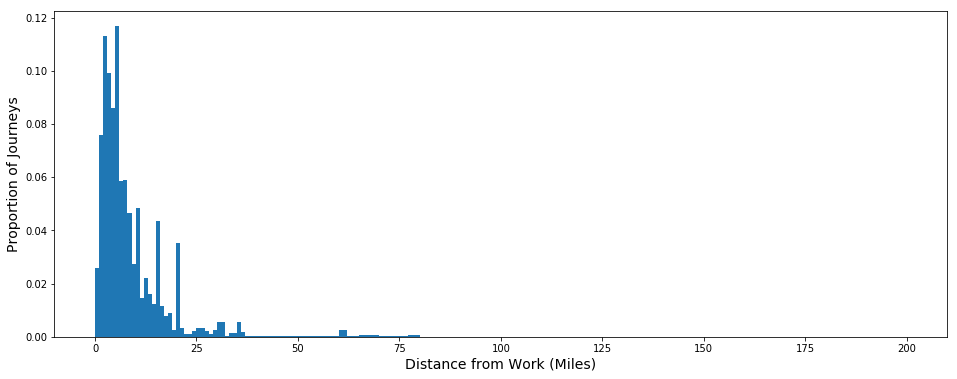

In [363]:
# Let's look at the breakdown of distances travelled by travel mode.
cardists = wf_indivs.loc[(wf_indivs['workdis'].map(np.isreal))&(wf_indivs['worktrav'] == 'Car'),'workdis']
cardists = pd.to_numeric(cardists)

f, ax = plt.subplots(figsize = (16,6))

bins = np.array(sorted(cardists.unique()))
ax.hist(cardists,bins,density=True)
ax.set_xlabel('Distance from Work (Miles)',fontsize=14)
ax.set_ylabel('Proportion of Journeys',fontsize=14)

cardists.mean() # mean car dist is 8.97 miles, c. 14.4 km

In [14]:
# The data from understanding society tend to peak around values like 5, 10, 15, 20
# They are likely not that accurate, but may be useful for sorting the data.

In [39]:
# Let's instead look at some census flow data.
# This first table is of MSOA to MSOA flows by mode of travel to work.
# NB there is a comment at the bottom of the file, so we remove the bottom 3 rows.
flows_mode = pd.read_csv('../Data/MSOA_Flows_Modes.csv', skipfooter=4)

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [53]:
# The Origin and Destination fields are insane, so we need to convert them into something we can use.
# Truncating the origin so that it matches the 'name' field in the geospatial data should allow for standardisation.
flows_mode['orig_msoa11nm'] = flows_mode['Origins'].apply(lambda x: x.split(': ')[1])
flows_mode['dest_msoa11nm'] = flows_mode['Destinations'].apply(lambda x: x.split(': ')[1])

In [30]:
url = 'https://opendata.arcgis.com/datasets/826dc85fb600440889480f4d9dbb1a24_0.geojson'
msoa_json = requests.get(url).json()['features']
geom = [shape(d['geometry']) for d in msoa_json]
attr = [d['properties'] for d in msoa_json]
msoas = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})
msoas = msoas.to_crs({'init':'epsg:27700'})
msoas.head()

,msoa11cd,msoa11nm,msoa11nmw,objectid,st_areashape,st_lengthshape,geometry
0,E02000001,City of London 001,City of London 001,1,2.897837e+06,9297.741827,"POLYGON ((532155.5105428078 182165.4037105864,..."
1,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2,2.161565e+06,8307.071886,"POLYGON ((548879.5614259791 191097.5816356249,..."
2,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,3,2.141516e+06,9359.991638,"POLYGON ((548960.4116485086 189072.4196781875,..."
3,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,4,2.492948e+06,8476.616902,"POLYGON ((551551.8947572846 187364.9089934734,..."
4,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,5,1.187953e+06,7322.466319,"POLYGON ((549238.9222601792 187628.1722011371,..."


In [67]:
# merge in MSOA codes from geospatial data.
flows_mode = flows_mode.merge(msoas[['msoa11cd','msoa11nm']],left_on = 'orig_msoa11nm', right_on = 'msoa11nm')
flows_mode.rename(columns={'msoa11cd':'orig_msoa11cd'},inplace=True)
flows_mode.drop('msoa11nm', axis=1,inplace=True)
# *** #
flows_mode = flows_mode.merge(msoas[['msoa11cd','msoa11nm']],left_on = 'dest_msoa11nm', right_on = 'msoa11nm')
flows_mode.rename(columns={'msoa11cd':'dest_msoa11cd'},inplace=True)
flows_mode.drop('msoa11nm', axis=1,inplace=True)
# *** #
flows_mode.drop(['Origins','Destinations'], axis=1,inplace=True)
flows_mode.head()

,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 1] Method of travel to work All categories: Method of travel to work;,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 2] Method of travel to work Work mainly at or from home;,"Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 3] Method of travel to work Underground, metro, light rail, tram;",Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 4] Method of travel to work Train;,"Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 5] Method of travel to work Bus, minibus or coach;",Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 6] Method of travel to work Taxi;,"Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 7] Method of travel to work Motorcycle, scooter or moped;",Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 8] Method of travel to work Driving a car or van;,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 9] Method of travel to work Passenger in a car or van;,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 10] Method of travel to work Bicycle;,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 11] Method of travel to work On foot;,Interaction data:2011 SWS MSOA/SOA/Intermediate Zone [Location of usual residence and place of work by method of travel to work] - WU03UK - Safeguarded:[Table WU03UK; Cell 12] Method of travel to work Other method of transport to work;,orig_msoa11nm,dest_msoa11nm,orig_msoa11cd,dest_msoa11cd
0,136,0,7,111,1,0,1,14,0,2,0,0,Waltham Forest 001,City of London 001,E02000895,E02000001
1,383,0,37,324,3,0,2,8,0,8,1,0,Waltham Forest 002,City of London 001,E02000896,E02000001
2,178,0,52,112,3,0,0,7,1,3,0,0,Waltham Forest 003,City of London 001,E02000897,E02000001
3,191,0,24,150,4,0,1,11,0,1,0,0,Waltham Forest 004,City of London 001,E02000898,E02000001
4,162,0,32,106,4,1,0,12,1,4,1,1,Waltham Forest 005,City of London 001,E02000899,E02000001


In [75]:
# Finally, let's tidy up the variable names so that they are understandable.
columns = ['all_modes','home','metro','train','bus','taxi','motorcycle','car','car_passenger','bicycle','walk','other']
flows_mode.columns = columns + list(flows_mode.columns[-4:])
flows_mode.head()

,all_modes,home,metro,train,bus,taxi,motorcycle,car,car_passenger,bicycle,walk,other,orig_msoa11nm,dest_msoa11nm,orig_msoa11cd,dest_msoa11cd
0,136,0,7,111,1,0,1,14,0,2,0,0,Waltham Forest 001,City of London 001,E02000895,E02000001
1,383,0,37,324,3,0,2,8,0,8,1,0,Waltham Forest 002,City of London 001,E02000896,E02000001
2,178,0,52,112,3,0,0,7,1,3,0,0,Waltham Forest 003,City of London 001,E02000897,E02000001
3,191,0,24,150,4,0,1,11,0,1,0,0,Waltham Forest 004,City of London 001,E02000898,E02000001
4,162,0,32,106,4,1,0,12,1,4,1,1,Waltham Forest 005,City of London 001,E02000899,E02000001


In [97]:
# Now collapse the modes into the modes we are using in motivate - we'll be dropping 'home' and 'other'
modes = {'Public':['metro','train','bus'],'Car':['taxi','motorcycle','car','car_passenger'],'Cycle':['bicycle'],'Walk':['walk']}

mode_sums = {}
for agg_mode, modes in modes.items():
    mode_sums[agg_mode] = pd.Series(flows_mode.loc[:,modes].sum(axis=1),name=agg_mode)
flows = flows_mode[['orig_msoa11cd','orig_msoa11nm','dest_msoa11cd','dest_msoa11nm']].merge(pd.DataFrame(mode_sums), left_index=True, right_index=True)
flows.head()

,orig_msoa11cd,orig_msoa11nm,dest_msoa11cd,dest_msoa11nm,Car,Cycle,Public,Walk
0,E02000895,Waltham Forest 001,E02000001,City of London 001,15,2,119,0
1,E02000896,Waltham Forest 002,E02000001,City of London 001,10,8,364,1
2,E02000897,Waltham Forest 003,E02000001,City of London 001,8,3,167,0
3,E02000898,Waltham Forest 004,E02000001,City of London 001,12,1,178,0
4,E02000899,Waltham Forest 005,E02000001,City of London 001,14,4,142,1


In [109]:
# Now we need to add some straight-line distances to the origin-destination pairs
dists = []
for idx, row in flows.iterrows():
    orig_pnt = msoas.loc[msoas['msoa11cd']==row['orig_msoa11cd']]['geometry'].centroid.values[0]
    dists.append(msoas.loc[msoas['msoa11cd']==row['dest_msoa11cd']]['geometry'].centroid.distance(orig_pnt).values[0])
flows['dist'] = dists
flows.head()

,orig_msoa11cd,orig_msoa11nm,dest_msoa11cd,dest_msoa11nm,Car,Cycle,Public,Walk,dist
0,E02000895,Waltham Forest 001,E02000001,City of London 001,15,2,119,0,14544.265636
1,E02000896,Waltham Forest 002,E02000001,City of London 001,10,8,364,1,14941.604343
2,E02000897,Waltham Forest 003,E02000001,City of London 001,8,3,167,0,13619.625082
3,E02000898,Waltham Forest 004,E02000001,City of London 001,12,1,178,0,12985.348573
4,E02000899,Waltham Forest 005,E02000001,City of London 001,14,4,142,1,12631.627949


# Walk Distribution

In [122]:
# Now we can look at the distribution of travel distances by modes.
# We do this by effectively disaggregating/unpacking the flows
# walk distance
walk = flows[flows['Walk'] >0]
# Average walk commute = 2.64 km - this is about a 30 minute walk - might be a bit high?
(walk['Walk'] * walk['dist']).sum()/walk['Walk'].sum()

2640.617999765788

In [126]:
# unpack the walks
walk_dists = []
for idx, row in walk.iterrows():
    for i in range(0,row['Walk']):
        walk_dists.append(row['dist'])
walk_dists = np.array(walk_dists)
walk_dists.mean()

2640.6179997657896

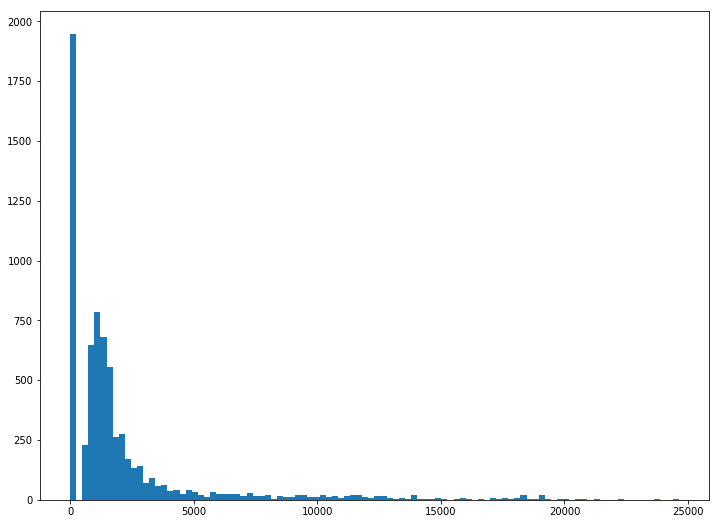

In [147]:
# zeroes represent within msoa commutes in Waltham Forest. c. 25% of all walks.
# reported walks have a curiously long tail of long walk commutes.
walk_dists = walk_dists[walk_dists < 25000] # get rid of the n=65 (0.9%) commutes > 25km.

# The gap represents the within msoa differences
f, ax = plt.subplots(figsize=(12,9))
ax.hist(walk_dists, bins=100);

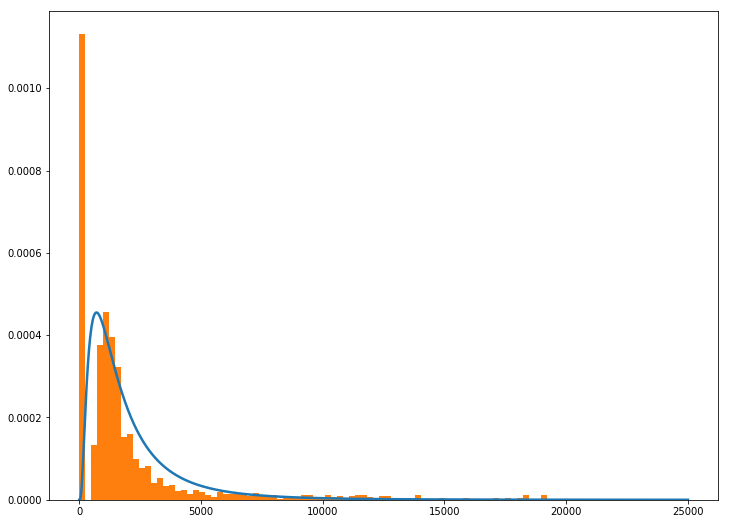

In [222]:
# I reckon that the lognormal is going to be a good model for walks, smoothing the zeroes out, but maintaining a right skew.
from scipy.stats import lognorm

f, ax = plt.subplots(figsize=(12,9))

# This is the fit based only on the data we have.
param = lognorm.fit(walk_dists,floc=0)
pdf = lognorm.pdf(np.linspace(0,25000,1000),param[0],loc=param[1],scale=param[2])
plt.plot(np.linspace(0,25000,1000),pdf, lw = 2.5)
ax.hist(walk_dists, bins=100,density=True);

In [162]:
# get the shape (std. dev), loc and scale (mean) parameters
print param
# random draw from the fitted lognormal
lognorm.rvs(param[0],param[1],param[2])

(0.85744580151979521, 0, 1476.6054358330252)


3200.8917735864352

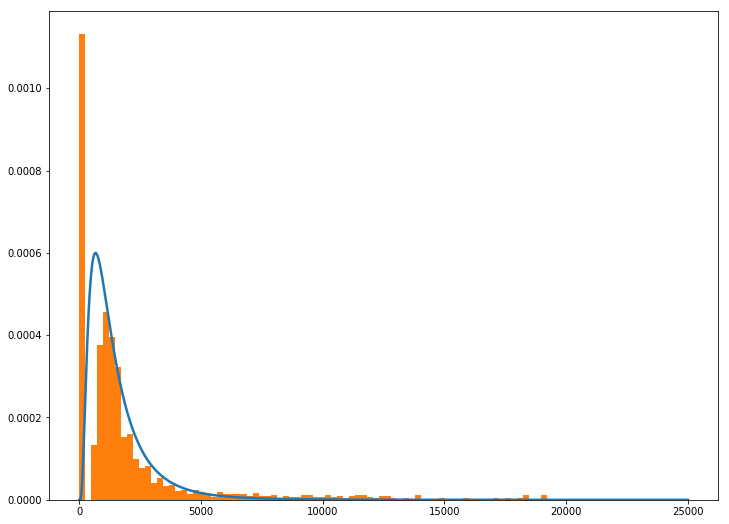

In [343]:
# I'm not that happy with the fitted lognormal against the right tail, so will try and tweak the fit.
f, ax = plt.subplots(figsize=(12,9))

# This is a guess.
pdf = lognorm.pdf(np.linspace(0,25000,1000),0.75,loc=0,scale=1175)
plt.plot(np.linspace(0,25000,1000),pdf, lw = 2.5)
ax.hist(walk_dists, bins=100,density=True);
# This looks good.
# params = 0.75, 0, 1175

# Cycle Distribution

In [168]:
cycle = flows[flows['Cycle'] >0]
# Average cycle commute = 7.72 km.
(cycle['Cycle'] * cycle['dist']).sum()/cycle['Cycle'].sum()

7718.2105829067195

In [174]:
# unpack the cycles
cycle_dists = []
for idx, row in cycle.iterrows():
    for i in range(0,row['Cycle']):
        cycle_dists.append(row['dist'])
cycle_dists = np.array(cycle_dists)
cycle_dists.mean()

7718.2105829067204

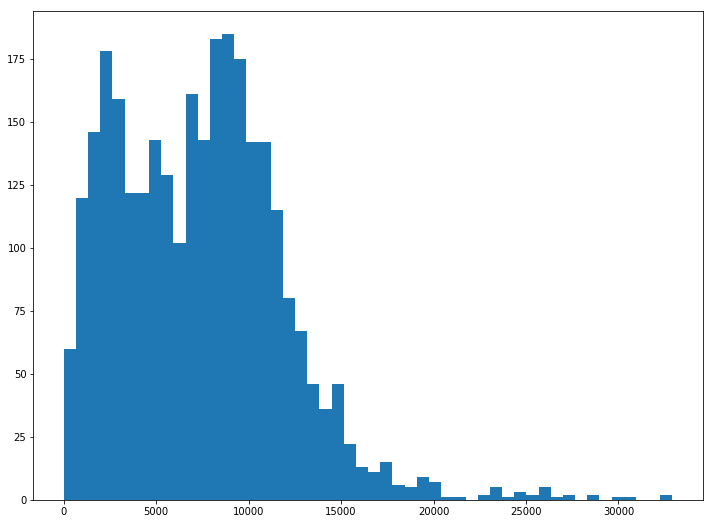

In [377]:
# zeroes represent within msoa commutes in Waltham Forest. c. 25% of all walks.
# reported walks have a curiously long tail of long walk commutes.
cycle_dists = cycle_dists[cycle_dists <= 40000] # get rid of the n=20 (0.7%) commutes > 25km.

f, ax = plt.subplots(figsize=(12,9))
ax.hist(cycle_dists, bins=50);

# looks broadly like a bimodal distribution, similar to the global pattern of commutes.
# Will attempt to use a mixture of gaussians to approximate this one.

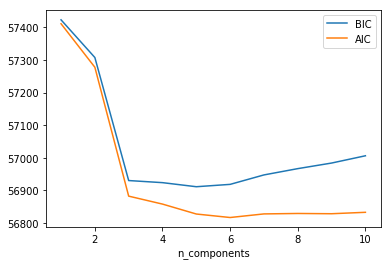

In [378]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=99).fit(np.expand_dims(cycle_dists,1))
          for n in n_components]

plt.plot(n_components, [m.bic(np.expand_dims(cycle_dists,1)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.expand_dims(cycle_dists,1)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# Somewhere between 3 and 6 components is best, we'll choose 3 for simplicity.

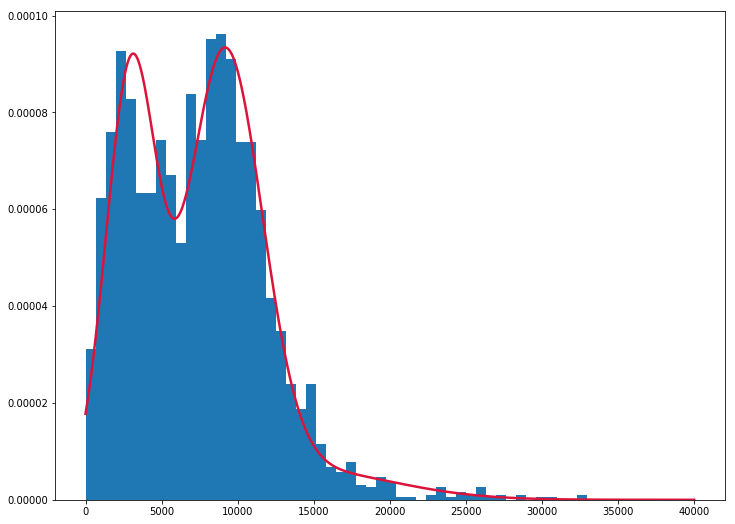

In [379]:
# 3 components works pretty well.
gmm = GaussianMixture(n_components=3,covariance_type='full')
gmm = gmm.fit(X = np.expand_dims(cycle_dists,1))

# Evaluate GMM
gmm_x = np.linspace(0,40000,1000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

f, ax = plt.subplots(figsize=(12,9))
ax.hist(cycle_dists, bins=50, density=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=2.5, label="GMM");

In [417]:
# Get the model components
print "means:", gmm.means_[0][0],",", gmm.means_[1][0],",", gmm.means_[2][0]
print "std. devs:", np.sqrt(gmm.covariances_[0][0][0]),",",np.sqrt(gmm.covariances_[1][0][0]),",",np.sqrt(gmm.covariances_[2][0][0])
print "weights:", gmm.weights_[0],",",gmm.weights_[1],",",gmm.weights_[2]

means: 9137.87807414 , 2982.73455673 , 14156.3250026
std. devs: 2449.21555611 , 1659.63048823 , 5925.8505006
weights: 0.546780230844 , 0.362044475394 , 0.0911752937624


# Cars (Private Transport)

In [238]:
car = flows[flows['Car'] >0]
# Average cycle commute = 9.36 km.
(car['Car'] * car['dist']).sum()/car['Car'].sum()

9358.838326825826

In [241]:
# unpack the cars
car_dists = []
for idx, row in car.iterrows():
    for i in range(0,row['Car']):
        car_dists.append(row['dist'])
car_dists = np.array(car_dists)
car_dists.mean()

9358.8383268258513

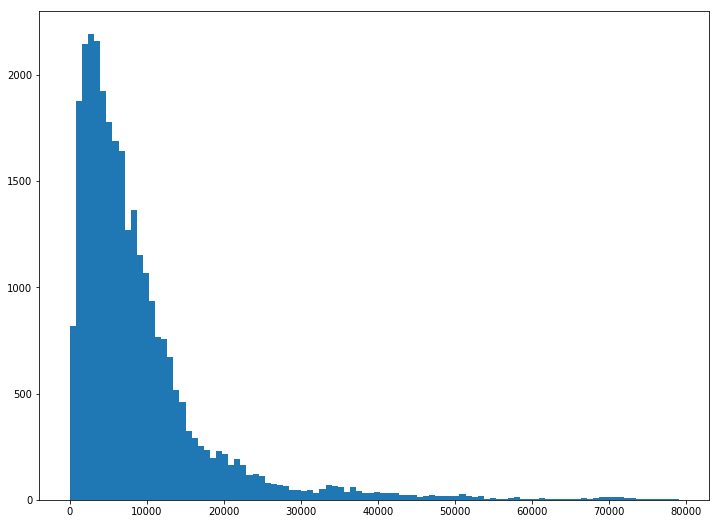

In [252]:
car_dists = car_dists[car_dists<=80000] # excludes tail, n=119 (0.4% of commutes)

f, ax = plt.subplots(figsize=(12,9))
ax.hist(car_dists, bins=100);

# slightly tricky distribution this, a lognormal might work though.

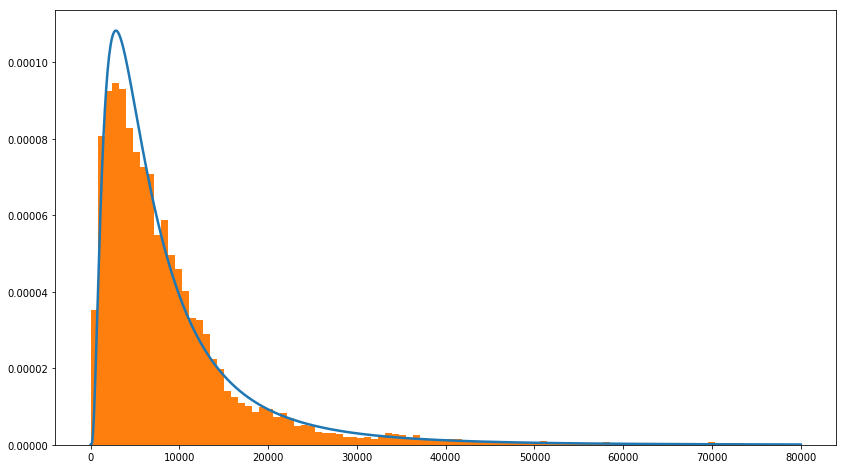

In [268]:
f, ax = plt.subplots(figsize=(14,8))

param = lognorm.fit(car_dists,floc=0)
pdf = lognorm.pdf(np.linspace(0,80000,1000),param[0],loc=param[1],scale=param[2])
ax.plot(np.linspace(0,80000,1000),pdf, lw = 2.5)
ax.hist(car_dists, bins=100,density=True);

# I think this is a reasonable fit, although it will overestimate local trips.
# Works a lot better than a gaussian mixture model.

In [273]:
# get params for lognormal distribution
# get the shape (std. dev), loc and scale (mean) parameters
print param
# random draw from the fitted lognormal
lognorm.rvs(param[0],param[1],param[2])

(0.87839072246042149, 0, 6166.9124954460649)


7314.3336612079802

# Public Transport (tube, train, bus)

In [274]:
public = flows[flows['Public'] >0]
# Average public transport commute = 10.72 km.
(public['Public'] * public['dist']).sum()/public['Public'].sum()

10717.66013296752

In [275]:
# unpack the public transport
public_dists = []
for idx, row in public.iterrows():
    for i in range(0,row['Public']):
        public_dists.append(row['dist'])
public_dists = np.array(public_dists)
public_dists.mean()

10717.66013296749

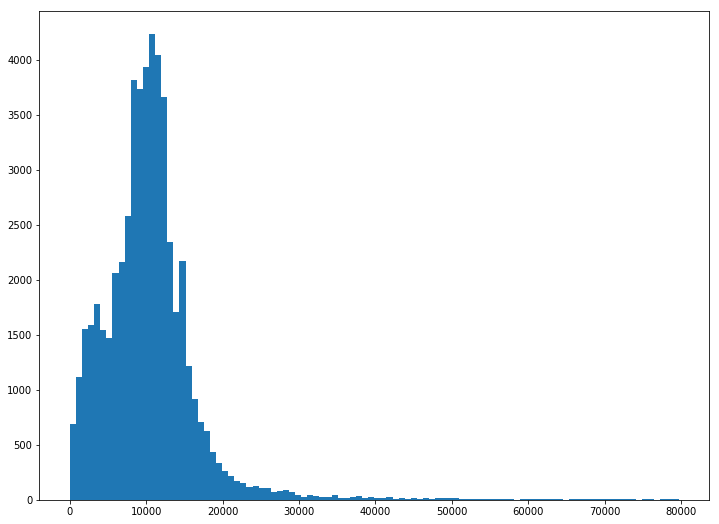

In [282]:
public_dists = public_dists[public_dists<=80000] # excludes tail, n=178 (0.3% of commutes)

f, ax = plt.subplots(figsize=(12,9))
ax.hist(public_dists, bins=100);

# A curious distribution for which a mixture of gaussians might work.

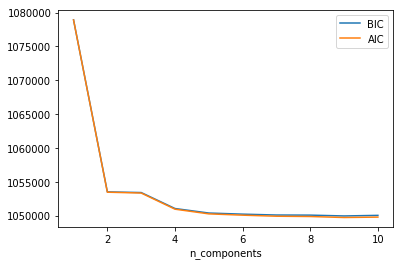

In [283]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=99).fit(np.expand_dims(public_dists,1))
          for n in n_components]

plt.plot(n_components, [m.bic(np.expand_dims(public_dists,1)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.expand_dims(public_dists,1)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# Somewhere between 2 and 6 components is best.
# We do seem to need 6 components here to do a decent job.

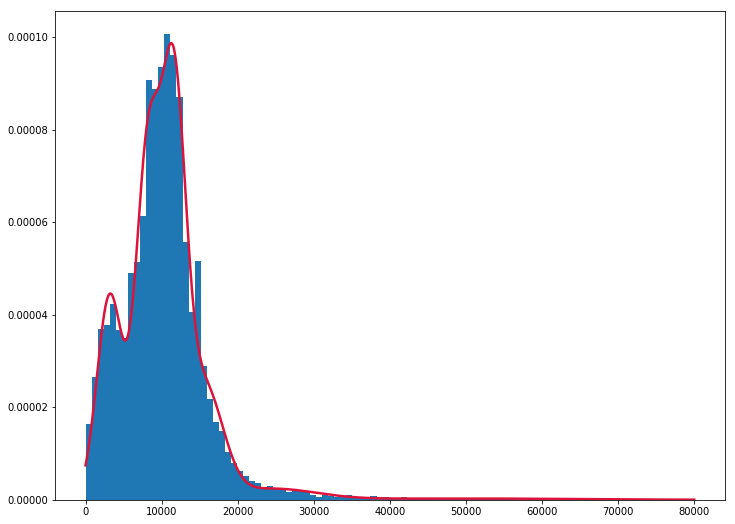

In [293]:
# 6 components produces a good representation of the distribution.
gmm = GaussianMixture(n_components=6,covariance_type='full')
gmm = gmm.fit(X = np.expand_dims(public_dists,1))

# Evaluate GMM
gmm_x = np.linspace(0,80000,1000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

f, ax = plt.subplots(figsize=(12,9))
ax.hist(public_dists, bins=100, density=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=2.5, label="GMM");

In [364]:
# Get the model components
print "means:", gmm.means_[0][0],",", gmm.means_[1][0],",", gmm.means_[2][0],",", gmm.means_[3][0],",", gmm.means_[4][0],",", gmm.means_[5][0]
print "std. devs:", np.sqrt(gmm.covariances_[0][0][0]),",",np.sqrt(gmm.covariances_[1][0][0]),",",np.sqrt(gmm.covariances_[2][0][0]),",",np.sqrt(gmm.covariances_[3][0][0]),",",np.sqrt(gmm.covariances_[4][0][0]),",",np.sqrt(gmm.covariances_[5][0][0])
print "weights:", gmm.weights_[0],",",gmm.weights_[1],",",gmm.weights_[2],",",gmm.weights_[3],",",gmm.weights_[4],",",gmm.weights_[5]

means: 3184.33245983 , 15627.6499253 , 11578.1475226 , 24537.2027739 , 49623.7544911 , 8188.58650357
std. devs: 1689.1334523 , 2445.21736775 , 1577.06089454 , 5701.70677765 , 14168.5799137 , 1598.55641828
weights: 0.186288357078 , 0.144633162853 , 0.331471791682 , 0.0336377162635 , 0.0099610217257 , 0.294007950397


# Allocate Distances to Simulated Data

In [369]:
# Get the count of individuals in the data by mode
wf_indivs.groupby('worktrav')['index'].count()

worktrav
Car             36378
Cycle            3239
Home             9220
Public          64089
Walk             7460
inapplicable    70592
Name: index, dtype: int64

In [431]:
# generate 7,460 walk journey distances.
# cap max distance walked at 10 km
walk_sim = []
for i in range(0,7460):
    cand = lognorm.rvs(0.75, 0, 1175)
    while cand > 10000:
        cand = lognorm.rvs(0.75, 0, 1175)
    walk_sim.append(cand)

In [422]:
# generate 3,239 cycle journey distances. More tricky as a gmm
cycle_sim = []

means = [9137.87807414, 2982.73455673, 14156.3250026]
stds = [2449.21555611, 1659.63048823, 5925.8505006]
distribs = [norm(mean, std) for (mean, std) in zip(means,stds)]
pick = np.cumsum([0.546780230844, 0.362044475394, 0.0911752937624])

def choose_positive(dist):
    cand = dist.rvs()
    # Always return 0 or a positive random number.
    # Is this legit?
    while np.sign(cand) == -1:
        cand = dist.rvs()
    return cand

for i in range(0,3239):
    rn = np.random.rand()
    if rn < pick[0]:
        cycle_sim.append(choose_positive(distribs[0]))
    elif rn < pick[1]:
        cycle_sim.append(choose_positive(distribs[1]))
    else:
        cycle_sim.append(choose_positive(distribs[2]))

In [438]:
# Generate 36,378 car journeys
# limit the max journey to 80 km
car_sim = []
for i in range(0,36378):
    cand = lognorm.rvs(0.87839072246042149, 0, 6166.9124954460649)
    while cand > 80000:
        cand = lognorm.rvs(0.87839072246042149, 0, 6166.9124954460649)
    car_sim.append(cand)

In [444]:
# Generate 64,089 public transport journeys
public_sim = []

means = [3184.33245983, 15627.6499253, 11578.1475226, 24537.2027739, 49623.7544911, 8188.58650357]
stds = [1689.1334523, 2445.21736775, 1577.06089454, 5701.70677765, 14168.5799137, 1598.55641828]
distribs = [norm(mean, std) for (mean, std) in zip(means,stds)]
pick = np.cumsum([0.186288357078, 0.144633162853, 0.331471791682, 0.0336377162635, 0.0099610217257, 0.294007950397])

for i in range(0,64089):
    rn = np.random.rand()
    if rn < pick[0]:
        public_sim.append(choose_positive(distribs[0]))
    elif rn < pick[1]:
        public_sim.append(choose_positive(distribs[1]))
    elif rn < pick[2]:
        public_sim.append(choose_positive(distribs[2]))
    elif rn < pick[3]:
        public_sim.append(choose_positive(distribs[3]))
    elif rn < pick[4]:
        public_sim.append(choose_positive(distribs[4]))
    else:
        public_sim.append(choose_positive(distribs[5]))

In [450]:
# Now apply these simulated distances to the appropriate subsets of simulated agent data
# walk
wf_indivs.loc[wf_indivs['worktrav'] == 'Walk','sim_dist'] = walk_sim
# cycle
wf_indivs.loc[wf_indivs['worktrav'] == 'Cycle','sim_dist'] = cycle_sim
# car
wf_indivs.loc[wf_indivs['worktrav'] == 'Car','sim_dist'] = car_sim
# Public transport
wf_indivs.loc[wf_indivs['worktrav'] == 'Public','sim_dist'] = public_sim

wf_indivs.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,f_workdis,ward,work_dis_class,workdis,sim_dist
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,3492.721765
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,12498.866719
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,12411.032400
3,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590,1.0,3,13794.974969
4,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590,1.0,3,17946.035446


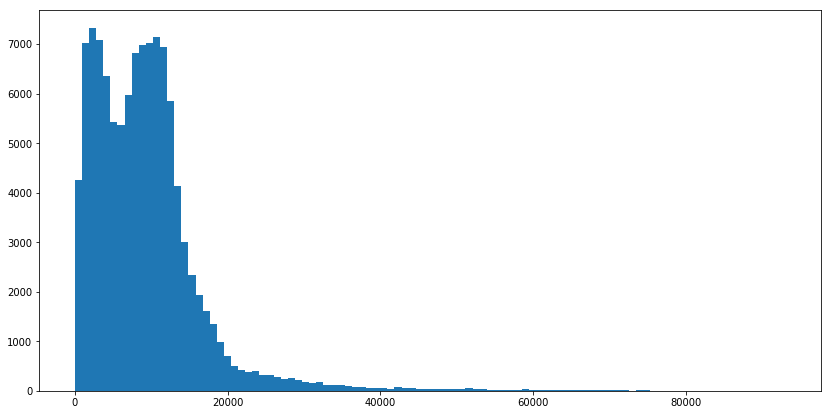

In [459]:
# check the combined histogram of simulated distances
f, ax = plt.subplots(figsize=(14,7))
ax.hist(wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public']),'sim_dist'],bins=100);
# This looks very similar to the distribution we see from LSOA to WZ flows!

In [460]:
# We wold like to classify these journeys into: local, city and beyond based on distance.
# We can explore this as previously with a gmm

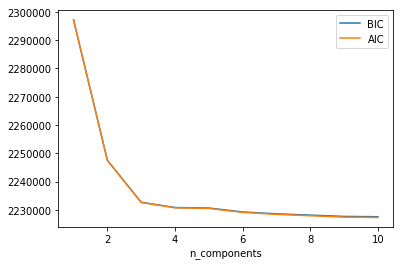

In [465]:
n_components = np.arange(1, 11)
X = wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public']),'sim_dist']
models = [GaussianMixture(n, covariance_type='full', random_state=99).fit(np.expand_dims(X,1))
          for n in n_components]

plt.plot(n_components, [m.bic(np.expand_dims(X,1)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.expand_dims(X,1)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# Somewhere between 3 and 6 components is best.
# 3 components does as good a job as higher component models, which seem to focus on fitting the right tail.
# Thus we'll use the 3 components.

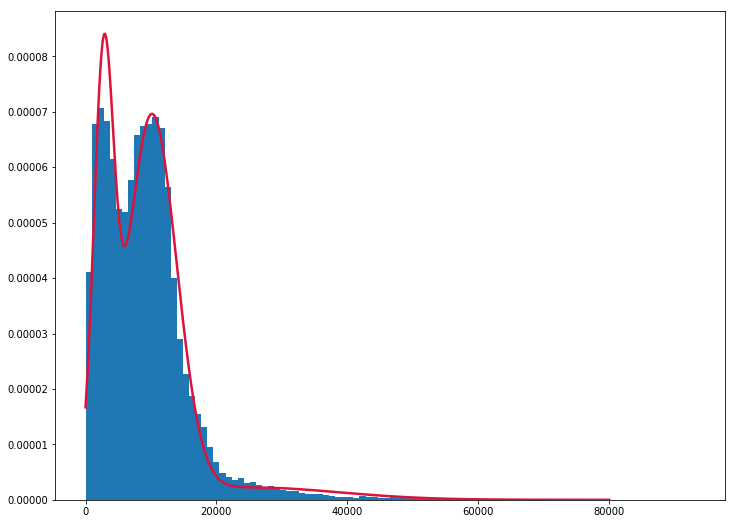

In [471]:
# 6 components produces a good representation of the distribution.
gmm = GaussianMixture(n_components=3,covariance_type='full')
gmm = gmm.fit(X = np.expand_dims(X,1))

# Evaluate GMM
gmm_x = np.linspace(0,80000,1000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

f, ax = plt.subplots(figsize=(12,9))
ax.hist(X, bins=100, density=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=2.5, label="GMM");

In [478]:
# Predict the classes.
classes = gmm.predict(X.values.reshape(-1,1))
wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public']),'trav_class'] = classes

In [487]:
wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public'])].groupby('trav_class')['sim_dist'].describe()
# class 0 is 'local' - trips of 0-4,943m (mean: 2,588m) - c. 30.4%
# class 1 is 'city' - trips of 4,944-20059m (mean: 10,536m) - c. 64.3%
# class 2 is 'beyond' - trips greater than 20,060m (mean: 31,096m) - c. 5.3%

,count,mean,std,min,25%,50%,75%,max
trav_class,,,,,,,,
0.0,33831.0,2587.766369,1302.948578,0.187425,1496.155250,2572.721875,3680.919971,4943.228829
1.0,71462.0,10536.124818,3438.684305,4943.547564,7845.520894,10225.525514,12655.341026,20058.956038
2.0,5873.0,31095.690065,11752.962289,20060.147511,22964.016597,27042.423958,34549.295918,92989.821693


In [490]:
wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public']),'trav_classnm'] = wf_indivs.loc[wf_indivs['worktrav'].isin(['Walk','Cycle','Car','Public']),'trav_class'].apply(lambda x: 'local' if x==0 else ('city' if x==1 else 'beyond'))
wf_indivs.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,f_workdis,ward,work_dis_class,workdis,sim_dist,trav_class,trav_classnm
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,3492.721765,0.0,local
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,12498.866719,1.0,city
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,5,E05000590,1.0,5,12411.032400,1.0,city
3,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590,1.0,3,13794.974969,1.0,city
4,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,3,E05000590,1.0,3,17946.035446,1.0,city


In [494]:
wf_indivs['trav_classnm'].value_counts(dropna=False)

NaN       79812
city      71462
local     33831
beyond     5873
Name: trav_classnm, dtype: int64

# Explore the commute classification

In [511]:
ct = pd.crosstab(wf_indivs['worktrav'],wf_indivs['trav_class'],normalize='index')
ct.columns = ['local','city','beyond']
ct
# Looks reasonable. 98% of walks are local. 40% of car journeys are local trips, but only 16% of public transport.

,local,city,beyond
worktrav,,,
Car,0.404503,0.508302,0.087196
Cycle,0.362766,0.623341,0.013893
Public,0.166284,0.792273,0.041442
Walk,0.976408,0.023592,0.000000


In [515]:
# mean trip length by mode and class
ct = pd.crosstab(wf_indivs['worktrav'],wf_indivs['trav_class'],values=wf_indivs['sim_dist'], aggfunc=np.mean)
ct.columns = ['local','city','beyond']
ct

,local,city,beyond
worktrav,,,
Car,2937.645612,9746.444280,30942.871439
Cycle,2857.662306,9500.335466,23536.585483
Public,2900.171170,10879.288093,31406.270031
Walk,1380.339302,6381.483579,NaN


In [516]:
ct = pd.crosstab(wf_indivs['worktrav'],wf_indivs['trav_class'],normalize='columns')
ct.columns = ['local','city','beyond']
ct
# 43% of local journeys are by car, 26% of all city journeys are by car.

,local,city,beyond
worktrav,,,
Car,0.434956,0.258753,0.540099
Cycle,0.034731,0.028253,0.007662
Public,0.315007,0.710531,0.452239
Walk,0.215305,0.002463,0.000000


In [518]:
# export the new wf_indivs dataset for use later.
wf_indivs.to_csv('../data/Synthetic_WF_complete.csv')